# Assignment 7: Predictive Modeling of Housing Prices in Philadelphia

## Haobing Liu

## Part 1: Proposal for the final project

Submit a short (1/2 to 1 page) proposal that outlines and describe your plan for the final project. The proposal should discuss the following aspects of the project:

- the data set(s) you wish to use in the project,
- the questions that you want to explore
- the analysis methods and techniques that you will use 
- how the above items satisfy the requirements outlined in the [final project description](https://github.com/MUSA-550-Fall-2022/final-project)

The description of the final project can be found [here](https://github.com/MUSA-550-Fall-2022/final-project).

**Note:** if you are struggling to come up with ideas for datasets, analyses, etc, please reach out and we can discuss potential project ideas.


#### Deliverable

Upload a word document, PDF, etc to the assignment's GitHub repository with your proposal.

#### Note
For the moment, do not worry too much about how the visualizations/interactive maps will be hosted on the web. We will cover several methods for embedding your visualizations on the web in the coming weeks. These methods fall generally into three categories:

- embedding interactive altair/holoviews plots produced in Python
- creating an interactive dashboard of plots using a free-tier server to host your code

Much more on these methods in the coming weeks!


## Part 2: Modeling Philadelphia's Housing Prices and Algorithmic Fairness


### 2.1 Load data from the Office of Property Assessment

Use `carto2gpd` to load data for **single-family** properties in Philadelphia that had their **last sale during 2021**.

Sources: 
- [OpenDataPhilly](https://www.opendataphilly.org/dataset/opa-property-assessments)
- [Metadata](http://metadata.phila.gov/#home/datasetdetails/5543865f20583086178c4ee5/representationdetails/55d624fdad35c7e854cb21a4/)

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import hvplot.pandas
import esri2gpd
import carto2gpd
import seaborn as sns
import osmnx as ox

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder

# Neighbors
from sklearn.neighbors import NearestNeighbors

In [ ]:
#the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

#the table name, properties data from the Office of Property Assessment
table_name = "opa_properties_public"

#load 2021 data for single-family properties
where = "sale_date >= '2021-01-01' AND sale_date < '2021-12-31'" 
where = where + " AND category_code_description IN ('SINGLE FAMILY', 'Single Family')"

#get the data
rawdata = carto2gpd.get(carto_url, table_name, where=where)

In [ ]:
rawdata.head()

,geometry,cartodb_id,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,unfinished,unit,utility,view_type,year_built,year_built_estimate,zip_code,zoning,pin,objectid
0,POINT (-75.19667 39.93733),937,2021-07-16T00:00:00Z,None,164' S WHARTON ST,54096200,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,None,None,None,I,1925,Y,19146,RSA5,1001649631,232159741
1,POINT (-75.16623 39.94166),999,2022-03-09T00:00:00Z,A,SWC BROAD & FITZWATER STS,53950012,SC,VACANT LAND COMMER < ACRE,1,SINGLE FAMILY,...,None,None,None,I,2021,None,19146,CMX3,1001681202,232159697
2,POINT (-75.02846 40.11039),1150,2021-07-16T00:00:00Z,F,"89'11 1/2"" NE SEL459",54095903,K30,S/D W/B GAR 2 STY MASONRY,1,SINGLE FAMILY,...,None,None,None,I,1968,Y,19116,RSA3,1001476645,232159847
3,POINT (-75.14689 40.05641),1253,2021-07-16T00:00:00Z,H,"152'6"" N 67TH AVE",54095296,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,...,None,None,None,I,1925,Y,19126,RSA5,1001097499,232159963
4,POINT (-75.24216 39.95278),1260,2021-07-16T00:00:00Z,None,106'S OF HAZEL AVE,54094927,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,None,None,None,I,1925,Y,19143,RM1,1001469933,232159970


As we can see, there are 25683 pieces of records in the dataset.

In [ ]:
len(rawdata)

25695

### 2.2 Load data for census tracts and neighborhoods

Load various Philadelphia-based regions we will use in our analysis.

- Census tracts can be downloaded from: https://opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson
- Neighborhoods can be downloaded from:
https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson


In [12]:
censustracts = gpd.read_file('https://opendata.arcgis.com/datasets/8bc0786524a4486bb3cf0f9862ad0fbf_0.geojson')

In [13]:
len(censustracts)

384

In [ ]:
nhoods = (gpd.read_file('https://raw.githubusercontent.com/azavea/geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson').to_crs(epsg=4326))
nhoods = nhoods.rename(columns={"mapname": "neighborhood"})

### 2.3 Spatially join the sales data and neighborhoods/census tracts.

Perform a spatial join, such that each sale has an associated neighborhood and census tract.

**Note:** after performing the first spatial join, you will need to use the `drop()` function to remove the `index_right` column; otherwise an error will be raised on the second spatial join about duplicate columns.

In [7]:
#the first spatial join with neighborhoods
rawdata = gpd.sjoin(rawdata, nhoods, op='within').drop(labels=['index_right'], axis=1)

/Users/paprika/opt/anaconda3/envs/musa-550-fall-2022/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [8]:
#the second spatial join with census tracts
rawdata = gpd.sjoin(rawdata, censustracts, op='within')

/Users/paprika/opt/anaconda3/envs/musa-550-fall-2022/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [9]:
#after spatial join, there are 101 columns in rawdata.
rawdata.head()

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO
0,POINT (-75.19667 39.93733),936,2021-07-16T00:00:00Z,None,164' S WHARTON ST,54096200,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,42101003300,33,Census Tract 33,G5020,S,1062354,72863,+39.9384405,-075.1958253,10376
203,POINT (-75.19299 39.93477),11396,2021-07-16T00:00:00Z,D,16' S DICKINSON ST,54028606,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,42101003300,33,Census Tract 33,G5020,S,1062354,72863,+39.9384405,-075.1958253,10376
209,POINT (-75.19500 39.93682),11503,2021-07-16T00:00:00Z,C,274' S WHARTON ST,54029674,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,42101003300,33,Census Tract 33,G5020,S,1062354,72863,+39.9384405,-075.1958253,10376
394,POINT (-75.19185 39.93622),14532,2021-07-16T00:00:00Z,A,343' S WHARTON ST,54009965,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,42101003300,33,Census Tract 33,G5020,S,1062354,72863,+39.9384405,-075.1958253,10376
407,POINT (-75.18958 39.93556),14664,2021-07-16T00:00:00Z,G,30' S REED ST,54007427,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,42101003300,33,Census Tract 33,G5020,S,1062354,72863,+39.9384405,-075.1958253,10376


In [10]:
#select the columns
cols = [
    "basements",
    "fireplaces",
    "interior_condition",
    "exterior_condition",
    "garage_spaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "market_value",
    "sale_price",
    "total_area",
    "total_livable_area",
    "neighborhood",
]

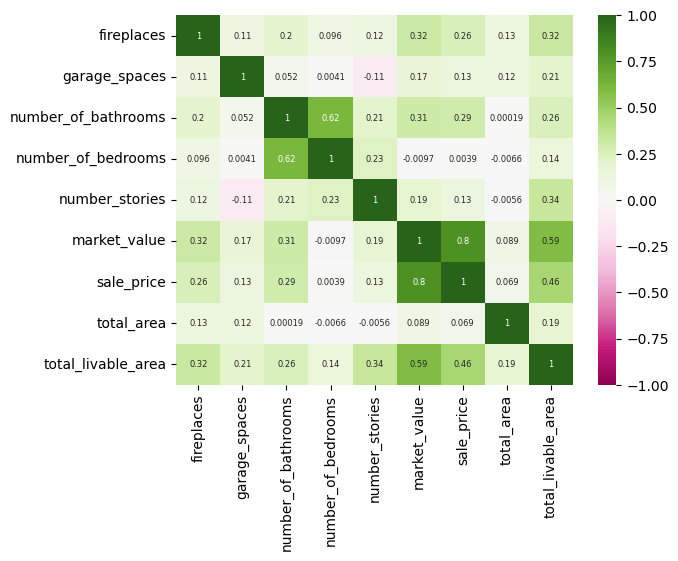

In [11]:
#use seaborn to investigate and create a heatmap to examine correlations between variables.
#we don't want to include multipl features that are highly correlated in our model.
sns.heatmap(
    rawdata[cols].corr(), cmap="PiYG", annot=True, vmin=-1, vmax=1, annot_kws={'size': 6});

In [12]:
# Trim to these columns and remove NaNs
sales = rawdata[cols + ["geometry"]].dropna()

In [13]:
len(sales)

17822

#### Feature Engineering

The probable features which may have impacts on model:
- subway or speta stations
- parks
- hospitals
- universities, colleges and schools
- landmarks such as city hall, museums, etc.

###### 1. Subway stations

In [14]:
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    
    Note: this works with both Point() and Polygon() objects.
    """
    # NEW: use the centroid.x and centroid.y to support Polygon() and Point() geometries 
    x = df.geometry.centroid.x
    y = df.geometry.centroid.y
    
    return np.column_stack((x, y)) # stack as columns

In [15]:
sales_3857 = sales.to_crs(epsg=3857)

In [16]:
# Extract x/y for sales
salesXY = get_xy_from_geometry(sales_3857)

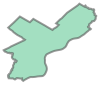

In [17]:
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/arcgis/rest/services/City_Limits/FeatureServer/0"
city_limits = esri2gpd.get(url).to_crs(epsg=3857)

city_limits_outline = city_limits.to_crs(epsg=4326).squeeze().geometry
city_limits_outline

In [18]:
# Get the subway stops within the city limits
subway = ox.geometries_from_polygon(city_limits_outline, tags={"station": "subway"})
# Convert to 3857 (meters)
subway = subway.to_crs(epsg=3857)

In [19]:
# STEP 1: x/y coordinates of subway stops (in EPGS=3857)
subwayXY = get_xy_from_geometry(subway.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm, use  𝑘=3  to get the distance to the nearest stop.
nbrs = NearestNeighbors(n_neighbors=3)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(subwayXY)

# STEP 4: Get distances for sale to neighbors
subwayDists, subwayIndices = nbrs.kneighbors(salesXY)

# STEP 5: add back to the original dataset
sales["logDistSubway"] = np.log10(subwayDists.mean(axis=1))

###### 2. Universities and colleges

In [20]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/Universities_Colleges/FeatureServer/0"
univs = esri2gpd.get(url)

In [21]:
# STEP 1: x/y coordinates of universities (in EPGS=3857)
univXY = get_xy_from_geometry(univs.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm, use  𝑘=1  to get the distance to the nearest one.
nbrs = NearestNeighbors(n_neighbors=1)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(univXY)

# STEP 4: Get distances for sale to neighbors
univDists, _ = nbrs.kneighbors(salesXY)

# STEP 5: add new feature to the original dataset
sales['logDistUniv'] = np.log10(univDists.mean(axis=1))

###### 3. Parks

In [22]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/PPR_Properties/FeatureServer/0"
parks = esri2gpd.get(url)

# Get the X/Y
parksXY = get_xy_from_geometry(parks.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=3)
nbrs.fit(parksXY)
parksDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistParks"] = np.log10(parksDists.mean(axis=1))

###### 4. Landmarks

In [23]:
# Get the data
url = "https://services.arcgis.com/fLeGjb7u4uXqeF9q/ArcGIS/rest/services/CITY_LANDMARKS/FeatureServer/0"
landmarks = esri2gpd.get(url)

# Get the X/Y
landmarksXY = get_xy_from_geometry(landmarks.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=3)
nbrs.fit(landmarksXY)
landmarksDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistLandmarks"] = np.log10(landmarksDists.mean(axis=1))

###### 5. Hospitals

In [24]:
#get the data
url = "https://opendata.arcgis.com/datasets/df8dc18412494e5abbb021e2f33057b2_0.geojson"
hospitals = gpd.read_file(url)

# Get the X/Y
hospXY = get_xy_from_geometry(hospitals.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(hospXY)
hospDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistHospitals"] = np.log10(hospDists.mean(axis=1))

###### 6. Commercials

In [25]:
#get the data
url = "https://opendata.arcgis.com/datasets/f43e5f92d34e41249e7a11f269792d11_0.geojson"
comm = gpd.read_file(url)


# Get the X/Y
commXY = get_xy_from_geometry(comm.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=2)
nbrs.fit(commXY)
commDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistCommercials"] = np.log10(commDists.mean(axis=1))

In [26]:
sales.head()

,basements,fireplaces,interior_condition,exterior_condition,garage_spaces,number_of_bathrooms,number_of_bedrooms,number_stories,market_value,sale_price,total_area,total_livable_area,neighborhood,geometry,logDistSubway,logDistUniv,logDistParks,logDistLandmarks,logDistHospitals,logDistCommercials
203,D,0.0,4,4,0.0,1.0,3.0,2.0,115700,1.0,705.0,1120.0,Grays Ferry,POINT (-75.19299 39.93477),3.465633,3.096089,2.633521,2.135708,3.338136,2.983366
209,C,0.0,4,4,0.0,1.0,3.0,2.0,100500,1.0,714.0,896.0,Grays Ferry,POINT (-75.19500 39.93682),3.467741,2.942790,2.592858,2.323589,3.278283,3.010303
394,A,0.0,2,2,0.0,2.0,2.0,2.0,258200,280000.0,728.0,976.0,Grays Ferry,POINT (-75.19185 39.93622),3.445679,3.069154,2.679880,2.377785,3.294503,2.960617
407,G,0.0,4,4,0.0,1.0,3.0,1.0,100600,1.0,708.0,1021.0,Grays Ferry,POINT (-75.18958 39.93556),3.415071,3.131868,2.755057,2.384392,3.321005,2.942907
629,D,0.0,4,4,0.0,1.0,3.0,2.0,173600,159900.0,997.0,1258.0,Grays Ferry,POINT (-75.18964 39.93588),3.418438,3.117052,2.764202,2.383400,3.310941,2.936595


### 2.4 Train a Random Forest on the sales data

You should follow the steps outlined in lecture to preprocess and train your model. 

**Extra credit: the students with the top 3 scores on the test set will receive extra credit (first place +3, second place +2, third place +1)**

**Requirements**
- Trim the sales data to those sales with prices between \\$3,000 and \\$1 million
- Set up a pipeline that includes both numerical columns and categorical columns
- Include one-hot encoded variables for the neighborhood of the sale
- Use a 70/30% training/test split
- Use GridSearchCV to perform a $k$-fold cross validation that optimize *at least 2* hyperparameters of the RandomForestRegressor
- After fitting your model and finding the optimal hyperparameters, you should evaluate the score ($R^2$) on the test set (the original 30% sample withheld)

**Notes**

- You are welcome to include additional features or perform any feature engineering that you want to try to improve the test accuracy
- You can also experiment with the prediction variable, e.g., try predicting sale price per sq ft. (or its log)

In [27]:
#select the columns I want to use
feature_cols = [
    "basements",
    "fireplaces",
    "interior_condition",
    "exterior_condition",
    "garage_spaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "market_value",
    "sale_price",
    "total_area",
    "total_livable_area",
    "neighborhood",
    "logDistSubway",
    "logDistUniv",
    "logDistParks",
    "logDistLandmarks",
    "logDistHospitals",
    "logDistCommercials"
]

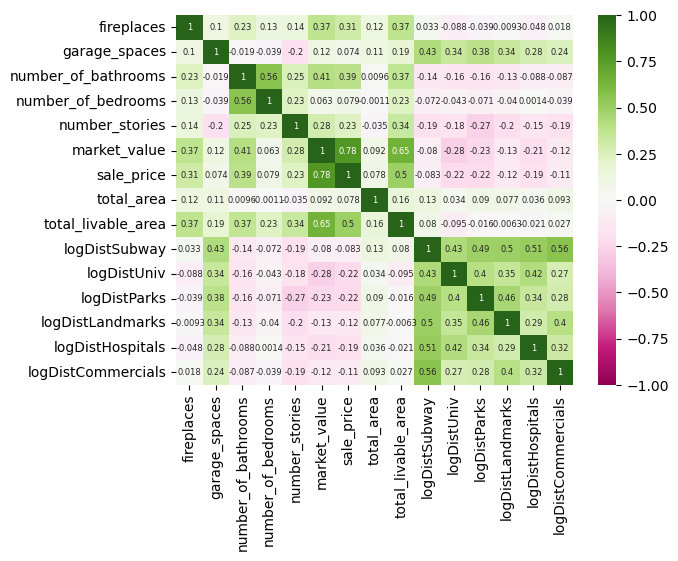

In [28]:
sns.heatmap(sales[feature_cols].corr(), cmap="PiYG", annot=True, vmin=-1, vmax=1, annot_kws={'size': 6});

In [29]:
prices = (sales['sale_price'] > 3000) & (sales['sale_price'] < 1e6)
sales = sales.loc[prices]
sales.head()

,basements,fireplaces,interior_condition,exterior_condition,garage_spaces,number_of_bathrooms,number_of_bedrooms,number_stories,market_value,sale_price,total_area,total_livable_area,neighborhood,geometry,logDistSubway,logDistUniv,logDistParks,logDistLandmarks,logDistHospitals,logDistCommercials
394,A,0.0,2,2,0.0,2.0,2.0,2.0,258200,280000.0,728.0,976.0,Grays Ferry,POINT (-75.19185 39.93622),3.445679,3.069154,2.679880,2.377785,3.294503,2.960617
629,D,0.0,4,4,0.0,1.0,3.0,2.0,173600,159900.0,997.0,1258.0,Grays Ferry,POINT (-75.18964 39.93588),3.418438,3.117052,2.764202,2.383400,3.310941,2.936595
915,D,0.0,4,4,0.0,1.0,3.0,2.0,103600,129900.0,793.0,1070.0,Grays Ferry,POINT (-75.19016 39.93520),3.422397,3.138679,2.720383,2.409399,3.329648,2.959023
1314,D,0.0,4,4,0.0,1.0,3.0,1.0,126800,240000.0,997.0,1262.0,Grays Ferry,POINT (-75.19552 39.93710),3.462848,2.907177,2.611036,2.275582,3.270724,3.023149
1337,C,0.0,3,4,0.0,1.0,3.0,2.0,142100,170000.0,767.0,1020.0,Grays Ferry,POINT (-75.19677 39.93461),3.508747,3.025167,2.639210,2.313193,3.351467,3.049064


In [30]:
len(sales)

14144

Use a 70/30% training/test split.

In [31]:
# Split the data 
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels: log of sale_price
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

In [32]:
# Numerical columns
num_cols = [
    "fireplaces",
    "garage_spaces",
    "number_of_bedrooms",
    "number_of_bathrooms",
    "number_stories",
    "market_value",
    "total_area",
    "total_livable_area",
    "logDistSubway",
    "logDistUniv",
    "logDistParks",
    "logDistLandmarks",
    "logDistHospitals",
    "logDistCommercials"
]

# Categorical columns
cat_cols = [
    "basements",
    "exterior_condition",
    "interior_condition",
    "neighborhood"
    ]

Set up a pipeline that includes both numerical columns and categorical columns.

In [33]:
# Set up the column transformer with two transformers
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Initialize the pipeline
pipe = make_pipeline(
    transformer, RandomForestRegressor(random_state=42)
)

In [34]:
# The column transformer...
transformer

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['fireplaces', 'garage_spaces',
                                  'number_of_bedrooms', 'number_of_bathrooms',
                                  'number_stories', 'market_value',
                                  'total_area', 'total_livable_area',
                                  'logDistSubway', 'logDistUniv',
                                  'logDistParks', 'logDistLandmarks',
                                  'logDistHospitals', 'logDistCommercials']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['basements', 'exterior_condition',
                                  'interior_condition', 'neighborhood'])])

In [35]:
# Make the grid of parameters to search
# NOTE: you must prepend the name of the pipeline step
model_name = "randomforestregressor"
param_grid = {
    f"{model_name}__n_estimators": [5, 20, 30, 50, 100],
    f"{model_name}__max_depth": [2, 5, 7, 9, 13]
}

param_grid

{'randomforestregressor__n_estimators': [5, 20, 30, 50, 100],
 'randomforestregressor__max_depth': [2, 5, 7, 9, 13]}

In [36]:
# Create the grid and use 5-fold CV
grid = GridSearchCV(pipe, param_grid, verbose=5, cv=5)

# Run the search
grid.fit(train_set, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5;, score=0.648 total time=   0.1s
[CV 2/5] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5;, score=0.662 total time=   0.1s
[CV 3/5] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5;, score=0.606 total time=   0.1s
[CV 4/5] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5;, score=0.638 total time=   0.1s
[CV 5/5] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=5;, score=0.641 total time=   0.1s
[CV 1/5] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20;, score=0.648 total time=   0.3s
[CV 2/5] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20;, score=0.662 total time=   0.3s
[CV 3/5] END randomforestregressor__max_depth=2, randomforestregressor__n_estimators=20;, score=

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['fireplaces',
                                                                          'garage_spaces',
                                                                          'number_of_bedrooms',
                                                                          'number_of_bathrooms',
                                                                          'number_stories',
                                                                          'market_value',
                                                                          'total_area',
                                                                          'total_livable_area',
                                                                          'logDistSubway',
                                                                          'logDistUniv',
                                                                          'logDistParks',
                                                                          'logDistLandmarks',
                                                                          'logDistHospitals',
                                                                          'logDistCommercials']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['basements',
                                                                          'exterior_condition',
                                                                          'interior_condition',
                                                                          'neighborhood'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             param_grid={'randomforestregressor__max_depth': [2, 5, 7, 9, 13],
                         'randomforestregressor__n_estimators': [5, 20, 30, 50,
                                                                 100]},
             verbose=5)

In [37]:
# Evaluate the best random forest model
best_random = grid.best_estimator_
best_random

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['fireplaces',
                                                   'garage_spaces',
                                                   'number_of_bedrooms',
                                                   'number_of_bathrooms',
                                                   'number_stories',
                                                   'market_value', 'total_area',
                                                   'total_livable_area',
                                                   'logDistSubway',
                                                   'logDistUniv',
                                                   'logDistParks',
                                                   'logDistLandmarks',
                                                   'logDistHospitals',
                                                   'logDistCommercials']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['basements',
                                                   'exterior_condition',
                                                   'interior_condition',
                                                   'neighborhood'])])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=7, random_state=42))])

In [38]:
grid.best_estimator_["randomforestregressor"]

RandomForestRegressor(max_depth=7, random_state=42)

In [39]:
grid.best_params_

{'randomforestregressor__max_depth': 7,
 'randomforestregressor__n_estimators': 100}

In [40]:
grid.score(test_set, y_test)

0.6949380653362948

In [41]:
pipe.fit(train_set, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['fireplaces',
                                                   'garage_spaces',
                                                   'number_of_bedrooms',
                                                   'number_of_bathrooms',
                                                   'number_stories',
                                                   'market_value', 'total_area',
                                                   'total_livable_area',
                                                   'logDistSubway',
                                                   'logDistUniv',
                                                   'logDistParks',
                                                   'logDistLandmarks',
                                                   'logDistHospitals',
                                                   'logDistCommercials']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['basements',
                                                   'exterior_condition',
                                                   'interior_condition',
                                                   'neighborhood'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [42]:
pipe.score(test_set, y_test) 

0.690210193729437

In [43]:
# Get the R2 on the test set!
best_random.score(test_set, y_test) #Finally I got 𝑅2 of ~0.69!

0.6949380653362948

The one-hot step

In [44]:
ohe = transformer.named_transformers_['cat']
ohe

OneHotEncoder(handle_unknown='ignore')

In [45]:
# One column for each category type!
ohe_cols = ohe.get_feature_names_out()
ohe_cols

array(['basements_0', 'basements_1', 'basements_4', 'basements_A',
       'basements_B', 'basements_C', 'basements_D', 'basements_E',
       'basements_F', 'basements_G', 'basements_H', 'basements_I',
       'basements_J', 'exterior_condition_1', 'exterior_condition_2',
       'exterior_condition_3', 'exterior_condition_4',
       'exterior_condition_5', 'exterior_condition_6',
       'exterior_condition_7', 'interior_condition_0',
       'interior_condition_1', 'interior_condition_2',
       'interior_condition_3', 'interior_condition_4',
       'interior_condition_5', 'interior_condition_6',
       'interior_condition_7', 'neighborhood_Academy Gardens',
       'neighborhood_Allegheny West', 'neighborhood_Andorra',
       'neighborhood_Aston-Woodbridge', 'neighborhood_Bartram Village',
       'neighborhood_Bella Vista', 'neighborhood_Belmont',
       'neighborhood_Brewerytown', 'neighborhood_Bridesburg',
       'neighborhood_Burholme', 'neighborhood_Bustleton',
       'neighborhood_Ca

In [46]:
features = num_cols + list(ohe_cols)
features

['fireplaces',
 'garage_spaces',
 'number_of_bedrooms',
 'number_of_bathrooms',
 'number_stories',
 'market_value',
 'total_area',
 'total_livable_area',
 'logDistSubway',
 'logDistUniv',
 'logDistParks',
 'logDistLandmarks',
 'logDistHospitals',
 'logDistCommercials',
 'basements_0',
 'basements_1',
 'basements_4',
 'basements_A',
 'basements_B',
 'basements_C',
 'basements_D',
 'basements_E',
 'basements_F',
 'basements_G',
 'basements_H',
 'basements_I',
 'basements_J',
 'exterior_condition_1',
 'exterior_condition_2',
 'exterior_condition_3',
 'exterior_condition_4',
 'exterior_condition_5',
 'exterior_condition_6',
 'exterior_condition_7',
 'interior_condition_0',
 'interior_condition_1',
 'interior_condition_2',
 'interior_condition_3',
 'interior_condition_4',
 'interior_condition_5',
 'interior_condition_6',
 'interior_condition_7',
 'neighborhood_Academy Gardens',
 'neighborhood_Allegheny West',
 'neighborhood_Andorra',
 'neighborhood_Aston-Woodbridge',
 'neighborhood_Bartram 

In [47]:
random_forest = pipe["randomforestregressor"]

# Create the dataframe with importances
importance = pd.DataFrame(
    {"Feature": features, "Importance": random_forest.feature_importances_}
)

In [48]:
# Sort by importance and get the top 20, and sort in a descending order
importance = importance.sort_values("Importance", ascending=False).iloc[:20]

# Plot
importance.hvplot.barh(x="Feature", y="Importance", height=500, flip_yaxis=True)

:Bars   [Feature]   (Importance)

### 2.5 Calculate the percent error of your model predictions for each sale in the test set

Fit your best model and use it to make predictions on the test set.

**Note:** this should be the percent error in terms of **sale price** or **sale price per sq ft**. You'll need to convert if you predicted the log!

In [49]:
# Make the predictions
predictions = best_random.predict(test_set)

# MAE
# NOTE: we convert from log(sale_price) to sale_price using exp()
errors = (np.exp(predictions) - np.exp(y_test)) / np.exp(y_test) * 100

In [50]:
errors.head()

5566    -26.075325
13469   -29.722149
15092    -5.411440
13491   -51.750883
17360   -33.025148
Name: sale_price, dtype: float64

### 2.6 Make a data frame with percent errors and census tract info for each sale in the test set

Create a data frame that has the property geometries, census tract data, and percent errors for all of the sales in the test set.

**Notes**

- When using the "train_test_split()" function, the index of the test data frame includes the labels from the original sales data frame
- You can use this index to slice out the test data from the original sales data frame, which should include the census tract info and geometries
- Add a new column to this data frame holding the percent error data



In [51]:
from sklearn.model_selection import train_test_split

In [52]:
#extract out the test set data
sales_test = rawdata.loc[test_set.index]

#include the percent error for all of the sales in the test set
sales_test['percent_error'] =  errors
sales_test.head()

,geometry,cartodb_id_left,assessment_date,basements,beginning_point,book_and_page,building_code,building_code_description,category_code,category_code_description,...,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,percent_error
5566,POINT (-75.17910 39.92920),25954,2021-07-16T00:00:00Z,D,142'W 20TH ST,53944416,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,37.01,Census Tract 37.01,G5020,S,355619,0,+39.9276728,-075.1806654,10378,-26.075325
13469,POINT (-75.17166 39.94806),35467,2021-07-16T00:00:00Z,0,114' W 18TH ST,53874981,570,RES CONDO 4 STY MASONRY,1,SINGLE FAMILY,...,8.03,Census Tract 8.03,G5020,S,152820,0,+39.9493748,-075.1742489,10344,-29.722149
15092,POINT (-75.10885 40.04584),37436,2021-07-16T00:00:00Z,H,"57'9"" N E CHELTENHAM",53868718,R30,ROW B/GAR 2 STY MASONRY,1,SINGLE FAMILY,...,305.02,Census Tract 305.02,G5020,S,699246,0,+40.0457206,-075.1046619,10616,-5.411440
13491,POINT (-75.22130 39.96825),35499,2021-07-16T00:00:00Z,D,"256'8 3/8"" N OF OGDEN",53875964,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,104,Census Tract 104,G5020,S,472051,0,+39.9654995,-075.2191193,10438,-51.750883
17360,POINT (-75.15118 39.91786),40264,2021-07-16T00:00:00Z,D,"72'8"" S RITNER ST",53863211,O30,ROW 2 STY MASONRY,1,SINGLE FAMILY,...,42.02,Census Tract 42.02,G5020,S,453343,0,+39.9168570,-075.1516284,10388,-33.025148


### 2.8 Plot a map of the median percent error by census tract 

- You'll want to group your data frame of test sales by the `GEOID10` column and take the median of you percent error column
- Merge the census tract geometries back in and use geopandas to plot.

In [53]:
#merge censustracts with sales_test, and take the median of the percent error column
error_test = censustracts.merge(sales_test.groupby("GEOID10")["percent_error"].median().reset_index(), on="GEOID10")
error_test.head()

,OBJECTID,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,LOGRECNO,geometry,percent_error
0,1,42,101,009400,42101009400,94,Census Tract 94,G5020,S,366717,0,+39.9632709,-075.2322437,10429,"POLYGON ((-75.22927 39.96054, -75.22865 39.960...",-15.773175
1,2,42,101,009500,42101009500,95,Census Tract 95,G5020,S,319070,0,+39.9658709,-075.2379140,10430,"POLYGON ((-75.23536 39.96852, -75.23545 39.969...",0.368265
2,3,42,101,009600,42101009600,96,Census Tract 96,G5020,S,405273,0,+39.9655396,-075.2435075,10431,"POLYGON ((-75.24343 39.96230, -75.24339 39.962...",3.462282
3,4,42,101,013800,42101013800,138,Census Tract 138,G5020,S,341256,0,+39.9764504,-075.1771771,10468,"POLYGON ((-75.17341 39.97779, -75.17386 39.977...",-5.965306
4,5,42,101,013900,42101013900,139,Census Tract 139,G5020,S,562934,0,+39.9750563,-075.1711846,10469,"POLYGON ((-75.17313 39.97776, -75.17321 39.977...",10.536333


/Users/paprika/opt/anaconda3/envs/musa-550-fall-2022/lib/python3.9/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/paprika/opt/anaconda3/envs/musa-550-fall-2022/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


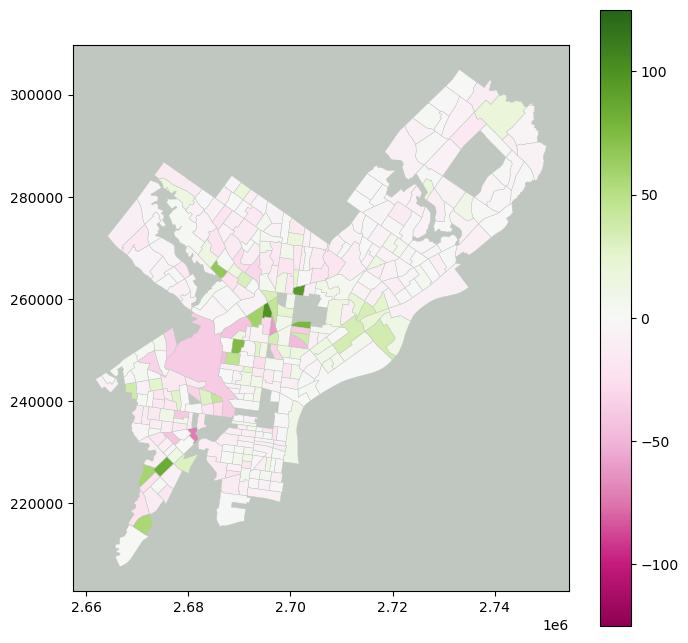

In [54]:
#plot a median error map
fig, ax = plt.subplots(figsize=(8, 8))

error_test.to_crs(epsg=2272).plot(
    ax=ax, 
    column="percent_error", 
    vmin=-125, 
    vmax=125,
    legend=True, 
    cmap='PiYG', 
    edgecolor='#bfc7c0', 
    linewidth=0.3
)

ax.set_facecolor("#bfc7c0")

### 2.9 Compare the percent errors in Qualifying Census Tracts and other tracts 

[Qualifying Census Tracts](https://www.huduser.gov/portal/datasets/qct.html) are a poverty designation that HUD uses to allocate housing tax credits

- I've included a list of the census tract names that qualify in Philadelphia
- Add a new column to your dataframe of test set sales that is True/False depending on if the tract is a QCT
- Then, group by this new column and calculate the median percent error

**You should find that the algorithm's accuracy is significantly worse in these low-income, qualifying census tracts**

In [55]:
qct = ['5',
 '20',
 '22',
 '28.01',
 '30.01',
 '30.02',
 '31',
 '32',
 '33',
 '36',
 '37.01',
 '37.02',
 '39.01',
 '41.01',
 '41.02',
 '56',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '69',
 '70',
 '71.01',
 '71.02',
 '72',
 '73',
 '74',
 '77',
 '78',
 '80',
 '81.01',
 '81.02',
 '82',
 '83.01',
 '83.02',
 '84',
 '85',
 '86.01',
 '86.02',
 '87.01',
 '87.02',
 '88.01',
 '88.02',
 '90',
 '91',
 '92',
 '93',
 '94',
 '95',
 '96',
 '98.01',
 '100',
 '101',
 '102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '119',
 '121',
 '122.01',
 '122.03',
 '131',
 '132',
 '137',
 '138',
 '139',
 '140',
 '141',
 '144',
 '145',
 '146',
 '147',
 '148',
 '149',
 '151.01',
 '151.02',
 '152',
 '153',
 '156',
 '157',
 '161',
 '162',
 '163',
 '164',
 '165',
 '167.01',
 '167.02',
 '168',
 '169.01',
 '169.02',
 '170',
 '171',
 '172.01',
 '172.02',
 '173',
 '174',
 '175',
 '176.01',
 '176.02',
 '177.01',
 '177.02',
 '178',
 '179',
 '180.02',
 '188',
 '190',
 '191',
 '192',
 '195.01',
 '195.02',
 '197',
 '198',
 '199',
 '200',
 '201.01',
 '201.02',
 '202',
 '203',
 '204',
 '205',
 '206',
 '208',
 '239',
 '240',
 '241',
 '242',
 '243',
 '244',
 '245',
 '246',
 '247',
 '249',
 '252',
 '253',
 '265',
 '267',
 '268',
 '271',
 '274.01',
 '274.02',
 '275',
 '276',
 '277',
 '278',
 '279.01',
 '279.02',
 '280',
 '281',
 '282',
 '283',
 '284',
 '285',
 '286',
 '287',
 '288',
 '289.01',
 '289.02',
 '290',
 '291',
 '293',
 '294',
 '298',
 '299',
 '300',
 '301',
 '302',
 '305.01',
 '305.02',
 '309',
 '311.01',
 '312',
 '313',
 '314.01',
 '314.02',
 '316',
 '318',
 '319',
 '321',
 '325',
 '329',
 '330',
 '337.01',
 '345.01',
 '357.01',
 '376',
 '377',
 '380',
 '381',
 '382',
 '383',
 '389',
 '390']

In [56]:
#Add a new column to dataframe of test set sales that is True/False depending on if the tract is a QCT
error_test['qct'] = False
error_test.loc[error_test['NAME10'].isin(qct), 'qct'] = True

In [57]:
#calculate the median percent error for each tract in QCT list
error_test.groupby("qct")["percent_error"].median()

qct
False   -3.722588
True    -2.040164
Name: percent_error, dtype: float64